In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

In [2]:
sns.set_theme()

Remarks
- No date of transaction (wtf)

Hypotheses
- Price of sell is negociated at -10% max
- Chambres NA with Pièces 1 can be replaced by 0. It can be considered as 'Chambre séparée', which is not the case in a studio
- High precision of Superficie, when multiple rows, is considered outlier (i.e. 24.00030284m2 should be a single row that might have been duplicated)

Improve
- Better imputation of Chambres NA with 3 & 4 Pièces (deleted 8%! of whole data here)

# Load data

In [3]:
prices = pd.read_csv('Prix IDF.xlsx - Prix.csv')
rentals = pd.read_csv('Prix IDF.xlsx - Loyer.csv')

In [4]:
prices.shape

(44685, 6)

In [5]:
prices.head()

,Code Postal,Ville,Pièces,Chambres,Superficie,Prix de vente
0,75001,PARIS,3,2.0,93,1680000.0
1,75001,PARIS,3,2.0,"87,4",1295000.0
2,75001,PARIS,5,4.0,"115,19",1905000.0
3,75001,PARIS,4,4.0,"93,5",1177000.0
4,75001,PARIS,2,1.0,54,870000.0


In [6]:
rentals.shape

(16014, 7)

In [7]:
rentals.head()

,Unnamed: 0,Code Postal,Ville,Pièces,Chambres,Superficie,Loyer
0,0,75001,PARIS,3,1.0,71,2150
1,1,75001,PARIS,2,1.0,35,1600
2,2,75001,PARIS,2,1.0,50,2515
3,3,75001,PARIS,1,NaN,35,1380
4,4,75001,PARIS,2,1.0,42,1700


# Clean data

In [8]:
# Drop dead column
rentals.drop(['Unnamed: 0'], axis=1, inplace=True)

In [9]:
# Replace commas by points
prices = prices.replace(to_replace=',', value='.', regex=True)
rentals = rentals.replace(to_replace=',', value='.', regex=True)

## Cast

Cast variables into:
- Code Postal: category
- Ville: category
- Pièces: int
- Chambres: int  (TODO when NANs are imputed)
- Superficie: float
- Loyer: int
- Prix de vente: float

### Cast categories

In [10]:
# Cast Code Postal as category
prices['Code Postal'] = prices['Code Postal'].astype('category')
rentals['Code Postal'] = rentals['Code Postal'].astype('category')

# Cast Ville as category
prices['Ville'] = prices['Ville'].astype('category')
rentals['Ville'] = rentals['Ville'].astype('category')

### Cast Pièces (and clean)

In [11]:
# Get outliers
p_out = [val for val in prices['Pièces'] if float(val) != round(float(val))]
r_out = [val for val in rentals['Pièces'] if float(val) != round(float(val))]
print('prices', p_out)
print('rentals', r_out)

prices ['25.44', '54.54', '17.46', '130.44', '63.72', '194.56', '47.89']
rentals []


Prices:
- Few outliers
- Round to closest (as no importance) the outliers to cast as int
- Fun fact: only 1 house sold having 13 rooms. Whereas 20 and 6 were sold having 12 and 14 rooms respectivelly
- Max rooms in a sell: 195

Rentals:
- No outlier
- Max rooms in a rental: 20

In [12]:
# Prices: Cast from object to float
prices['Pièces'] = prices['Pièces'].astype('float64')
# Prices: Round
prices['Pièces'] = prices['Pièces'].apply(round)

In [13]:
# Cast to int64
prices['Pièces'] = prices['Pièces'].astype('int64')
rentals['Pièces'] = rentals['Pièces'].astype('int64')

### Cast Superficie

In [14]:
# a = prices['Superficie'].astype('float64', errors='ignore')
err = []
for v in prices['Superficie']:
    try:
        float(v)
    except:
        err.append(v)

In [15]:
err

['²1', '²1', '²1', '²1', '²1']

In [16]:
# Analyse errors
prices[prices['Superficie'] == '²1']

,Code Postal,Ville,Pièces,Chambres,Superficie,Prix de vente
34824,93300,Aubervilliers,55,NaN,²1,210000.0
34825,93300,Aubervilliers,17,NaN,²1,96000.0
34827,93300,Aubervilliers,64,NaN,²1,234000.0
34828,93300,Aubervilliers,195,NaN,²1,738000.0
34829,93300,Aubervilliers,48,NaN,²1,186000.0


- These are errors definitely, since houses with +17 rooms are incoherent with these prices
- Drop these outliers

In [17]:
# Drop outliers
ma_no_outliers = prices['Superficie'] == '²1'
prices = prices[~ma_no_outliers]

In [18]:
# Cast to float
prices['Superficie'] = prices['Superficie'].astype('float64')
rentals['Superficie'] = rentals['Superficie'].astype('float64')

### Cast Loyer to int64

In [19]:
rentals['Loyer'] = rentals['Loyer'].astype('int64')

### Cast Prix de vente

In [20]:
prices['Prix de vente'] = prices['Prix de vente'].astype('float64')

## Categorize

###  Code Postal (one-hot / better algo)

###  Ville (one-hot / better algo)

## Missing (NaN)

### NA Prix de vente
- 1 missing
- Dropped it
- if time left, impute it

In [21]:
# Prix de vente
ma_out_px = prices['Prix de vente'].isna()
prices[ma_out_px]

,Code Postal,Ville,Pièces,Chambres,Superficie,Prix de vente
38429,94100,Saint-Maur-des-Fossés,4,3.0,87.0,NaN


In [22]:
# Drop na
prices = prices[~ma_out_px]

### NA Chambres
- Some advertisements have many rooms, with might be explained by large rooms counting as multiple rooms [https://www.logic-immo.com/vendre/estimer-bien-immobilier/calculer-nombre-pieces-maison-appartement-1-20-40](cf)

Prices:
- NAs with Pièces <=2
- +8000 NAs with Pièces > 2

Rentals:
- Mostly NAs with Pièces <=2
- 71 NAs with Pièces > 2

Imputations:
- 0 when Pièces = 1
- 1 when Pièces = 2
- Dropped otherwise (can't tell whether Pièces or Chambres is wrong)

#### Study Prices

##### Analysis

(0.0, 200.0)

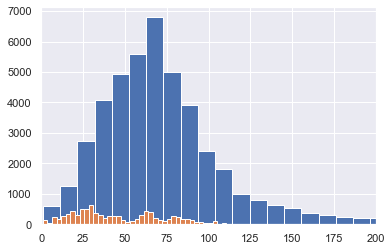

In [23]:
prices['Superficie'].hist(bins=150)
ma_na_chamb = prices['Chambres'].isna()
prices[ma_na_chamb]['Superficie'].hist(bins=150)
plt.xlim([0, 200])

(0.0, 10.0)

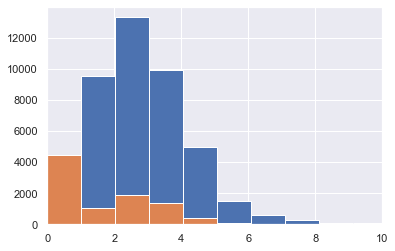

In [24]:
prices['Pièces'].hist(bins=150)
ma_na_pieces = prices['Chambres'].isna()
prices[ma_na_pieces]['Pièces'].hist(bins=150)
plt.xlim([0, 10])

- When missing and 1 Pièces only, it is a studio, and can be replaced by 0
- When there are 2 Pièces, NaN can be replaced by 1.
- For > 2 Pièces, its hard to tell.

In [25]:
# Distribution of Chambres for 3 Pièces
ma_pieces_px_3 = prices['Pièces'] == 3
prices[ma_pieces_px_3]['Chambres'].value_counts

<bound method IndexOpsMixin.value_counts of 0        2.0
1        2.0
5        2.0
9        1.0
14       2.0
        ... 
44666    NaN
44670    2.0
44672    2.0
44676    2.0
44682    2.0
Name: Chambres, Length: 13315, dtype: float64>

- Chambres > 4 are obvious outliers
- Chambres = 3 & 4 are difficult to interpret. It might as well be an error in the number of Chambres than Pièces

<AxesSubplot:>

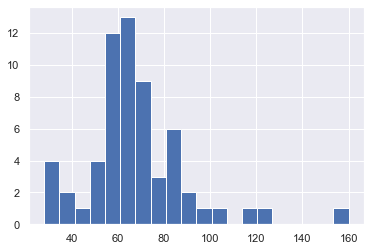

In [26]:
# Distribution Superficie for 3 Chambres 3 Pièces
ma_pieces_px_3 = prices['Pièces'] == 3
ma_chambres_px_3 = prices['Chambres'] == 3
prices[ma_pieces_px_3 & ma_chambres_px_3]['Superficie'].hist(bins=20)

- Although it is concentrated around 60m2, it is hard to tell whether it might have 3 Chambres or 2 Chambres
- Drop these records

##### Impute!

In [27]:
# Impute Chambre NA with 0 when Pièces is 1
ma_na_pieces_px = prices['Chambres'].isna()
ma_n_pieces_px_1 = prices['Pièces'] == 1
prices.loc[ma_na_pieces_px & ma_n_pieces_px_1, 'Chambres'] = 0

In [28]:
# Impute Chambre NA with 1 when Pièces is 2
ma_n_pieces_px_2 = prices['Pièces'] == 2
prices.loc[ma_na_pieces_px & ma_n_pieces_px_2, 'Chambres'] = 1

In [29]:
# /!\ Drop Chambre NA when Pièces > 2 (since hard to tell what it should be)
# /!\ Large data loss here
ma_na_pieces_px = prices['Chambres'].isna()
ma_n_pieces_px_large = prices['Pièces'] > 2
ma_idx_px_na = prices[ma_na_pieces_px & ma_n_pieces_px_large].index
prices.drop(ma_idx_px_na, inplace=True)

In [30]:
# Control NA are dropped (Not!)
prices[prices['Chambres'].isna()]

,Code Postal,Ville,Pièces,Chambres,Superficie,Prix de vente
30817,93100,Montreuil,0,NaN,363.0,747000.0
30947,93100,Montreuil,0,NaN,363.0,747000.0
44290,78000,Versailles,0,NaN,214.0,766500.0
44411,78000,Versailles,0,NaN,214.0,766500.0
44425,78000,Versailles,0,NaN,214.0,766500.0
44546,78000,Versailles,0,NaN,214.0,766500.0
44587,78000,Versailles,0,NaN,214.0,766500.0


In [31]:
# Control these NA come from Pièces being 0 (i.e. outliers) (Yes!)
prices[prices['Pièces'] == 0]

,Code Postal,Ville,Pièces,Chambres,Superficie,Prix de vente
30817,93100,Montreuil,0,NaN,363.0,747000.0
30947,93100,Montreuil,0,NaN,363.0,747000.0
44290,78000,Versailles,0,NaN,214.0,766500.0
44411,78000,Versailles,0,NaN,214.0,766500.0
44425,78000,Versailles,0,NaN,214.0,766500.0
44546,78000,Versailles,0,NaN,214.0,766500.0
44587,78000,Versailles,0,NaN,214.0,766500.0


In [32]:
# Drop remaining Chambres NAs
ma_chambre_px_na_r = prices[prices['Chambres'].isna()]
ma_chambre_px_na_r_idx = ma_chambre_px_na_r.index
prices.drop(ma_chambre_px_na_r_idx, inplace=True)

#### Study Rentals

(0.0, 8.0)

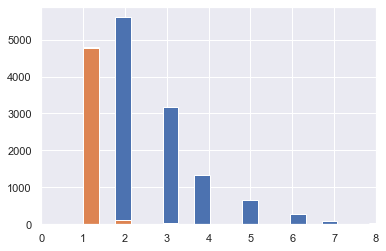

In [33]:
rentals['Pièces'].hist(bins=50)
ma_na_pieces_rent = rentals['Chambres'].isna()
rentals[ma_na_pieces_rent]['Pièces'].hist(bins=50)
plt.xlim([0, 8])

- There is an even clearer pattern, with missing Chambres representing studios
- NAs when 2 Chambres must be replaced by 1
- NAs can (almost all) be imputed with a 0 (or 1, to think) but surely < 2

In [34]:
# Impute Chambre NA with 1 when Pièces is 2
ma_na_pieces_rent = rentals['Chambres'].isna()
ma_n_pieces_2 = rentals['Pièces'] == 2
rentals.loc[ma_na_pieces_rent & ma_n_pieces_2, 'Chambres'] = 1

In [35]:
# Impute Chambre NA with 0 when Pièces is 1
ma_n_pieces_1 = rentals['Pièces'] == 1
rentals.loc[ma_na_pieces_rent & ma_n_pieces_1, 'Chambres'] = 0

In [36]:
# Drop when Pièces > 2 (71 NAs)
ma_na_ch_rent = rentals['Chambres'].isna()
rentals[ma_na_ch_rent]['Pièces'].value_counts()

3     45
4     17
5      4
6      1
7      1
9      1
10     1
20     1
Name: Pièces, dtype: int64

In [37]:
ma_na_ch_rent_idx = rentals[ma_na_ch_rent].index
rentals.drop(ma_na_ch_rent_idx, inplace=True)

### NA Superficie
- Prices: 25 NAs remaining
- Rentals: 27 NAs remaining

Imputation:
- Dropped, too complex to impute (range between large range of Loyer from 500 to 1200)

In [38]:
rentals.isna().sum()

Code Postal     0
Ville           0
Pièces          0
Chambres        0
Superficie     27
Loyer           0
dtype: int64

In [39]:
prices.isna().sum()

Code Postal       0
Ville             0
Pièces            0
Chambres          0
Superficie       25
Prix de vente     0
dtype: int64

- Drop Superficie NAs (too risky to impute a value - mean would be worse than dropped)

In [40]:
# Prices
ma_sup_px_na = prices['Superficie'].isna()
idx = prices[ma_sup_px_na].index
prices.drop(idx, inplace=True)

In [41]:
# Rentals
ma_sup_rent_na = rentals['Superficie'].isna()
idx = rentals[ma_sup_rent_na].index
rentals.drop(idx, inplace=True)

## Cast Chambres

In [42]:
prices['Chambres'] = prices['Chambres'].astype('int64')
rentals['Chambres'] = rentals['Chambres'].astype('int64')

In [43]:
# Clean!
rentals.dtypes

Code Postal    category
Ville          category
Pièces            int64
Chambres          int64
Superficie      float64
Loyer             int64
dtype: object

## Outliers

- Superficie lower than 8, inspect price coherence
- Same for highest Superficie
- Idem very low prices

Imputation:
- Prices: Drop Superficie < 8, it might correspond to announces that disrupt the system to be shown to everyone - prevent to be filtered out because of its large superficie

### Low Superficie

#### Prices

In [44]:
ma_sfcie_low = prices['Superficie'] < 8
prices[ma_sfcie_low]['Chambres'].value_counts()

0    154
1     47
Name: Chambres, dtype: int64

(60000.0, 1000000.0)

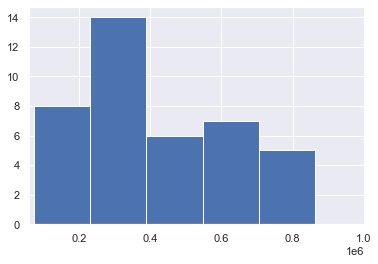

In [45]:
ma_sfcie_low = prices['Superficie'] < 8
ma_chm_1 = prices['Chambres'] == 1
prices[ma_sfcie_low & ma_chm_1]['Prix de vente'].hist()
plt.xlim([60000, 1000000])

- Too complex to impute (it might correspond to announces that disrupt the system to be shown to everyone - prevent to be filtered out because of its large superficie)
- Drop it!

In [46]:
# Drop all
idx = prices[ma_sfcie_low].index
prices.drop(idx, inplace=True)

#### Rentals

<AxesSubplot:>

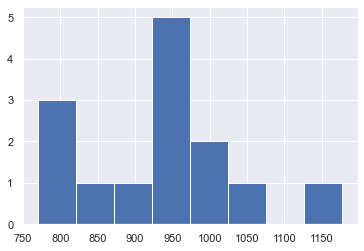

In [47]:
ma_sfcie_low = rentals['Superficie'] < 8
ma_chm_1 = rentals['Chambres'] == 1
rentals[ma_sfcie_low & ma_chm_1]['Loyer'].hist(bins=8)

- Too complex to impute
- Drop it!

In [48]:
# Drop when Superficie < 8
idx = rentals[ma_sfcie_low].index
rentals.drop(idx, inplace=True)

### High Superficie

In [49]:
ma = prices['Superficie'] > 400
prices[ma]

,Code Postal,Ville,Pièces,Chambres,Superficie,Prix de vente
24,75001,PARIS,7,4,400.66,18000000.0
49,75001,PARIS,7,4,400.66,18000000.0
169,75001,PARIS,7,4,470.00,18000000.0
194,75001,PARIS,7,4,470.00,18000000.0
235,75001,PARIS,8,4,400.66,18000000.0
...,...,...,...,...,...,...
20914,92130,Issy-les-Moulineaux,8,5,432.00,3500000.0
24446,92220,Bagneux,8,6,560.00,2630000.0
24483,92220,Bagneux,8,6,560.00,2630000.0
38653,94110,Arcueil,10,1,504.00,2080000.0


## Duplicates

In [50]:
r = prices.groupby(['Superficie', 'Prix de vente']).size()
r[r>1].value_counts()

2     6133
3     1402
4      641
5      202
6      107
7       49
8       21
9        9
10       4
11       3
12       1
20       1
58       1
50       1
34       1
23       1
87       1
dtype: int64

- Many duplicates, but could be real data, since a similar Superficie is logically sold at a similar price

In [51]:
# Inspect further by crossing with Code Postal TODO
r[r>10]

Superficie  Prix de vente
29.48       183000.0         20
30.00       450000.0         12
45.00       334000.0         34
46.00       540000.0         11
56.02       728000.0         11
64.00       210000.0         50
83.53       308800.0         87
96.00       425000.0         58
98.24       420000.0         23
100.00      1250000.0        11
dtype: int64

- Since no one could input twice a higly precise Superficie like 83.529999
- From these strange Superficie, one entry must be kept only (e.g. 1 of the 87)

# Further analysis

In [52]:
profile_prices = ProfileReport(prices, title="Prices report")
profile_prices.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Prices report analysis

- Many duplicated rows 21.6%. These are transactions and should not be treated as duplicates. With these variables, it is probable enough to have similar houses sold at the same price
- 'Chambres' is the only variable with missing values
- 'Ville' represents IDF, with Paris at 41.5%. 122 different cities (paris included)
- Code Postal 141 vs Ville 122. There exists multiple Code Postal in Paris (20)



Rentals report analysis

- 'Ville' also IDF, with 121 cities

Prices vs Rentals
- 1 ville / code Postal de moins dans rentals (vs prices) (92230, Gennevilliers)

In [53]:
code_px = prices['Code Postal'].unique()
code_rent = rentals['Code Postal'].unique()
[code for code in code_px if code not in code_rent]

[92230]

In [54]:
# plt.heat prices[prices[['Pièces', 'Chambres']].isna()]